### ENSIMAG – Grenoble INP – UGA - Academic year 2024-2025
# Introduction to Statistical Learning and Applications ([website](https://github.com/ISLA-Grenoble/2025-main))

- Pedro L. C. Rodrigues -- `pedro.rodrigues@inria.fr`

- Alexandre Wendling -- `alexandre.wendling@univ-grenoble-alpes.fr`

***

### ⚠️ General guidelines for TPs

Each team shall upload its report on [Teide](https://teide.ensimag.fr/) before the deadline indicated at the course website. Please
**include the name of all members** of the team on top of your report.
The report should contain graphical representations and explanatory text. For each graph, axis names should be provided as well
as a legend when it is appropriate. Figures should be explained by a few sentences in the text. Answer to
the questions in order and refer to the question number in your report. Computations and
graphics have to be performed in `python`. The report should be written as a jupyter notebook. This is a file format that allows users to format documents containing text written in markdown and `python` instructions. You should include all of the `python` instructions that you have used in the document so that it may be possible to replicate your results.

***

# 🖥️ TP1: Analysis of prostate cancer data

A medical study done on patients with prostate cancer aims to analyze the correlation between the prostate tumor volume and a set of clinical and morphometric variables. These variables include prostate specific antigens, a biomarker for prostate cancer, and a number of clinical measures (age, prostate weight, etc). The goal of this lab is to build a regression model to predict the severity of cancer, expressed by logarithm of the tumor volume -- `lcavol` variable -- from the following predictors:
- `lpsa`: log of a prostate specific antigen
- `lweight`: log of prostate weight
- `age`: age of the patient
- `lbph`: log of benign prostatic hyperplasia amount
- `svi`: seminal vesicle invasion
- `lcp`: log of capsular penetration
- `gleason`: Gleason score (score on a cancer prognosis test)
- `pgg45`: percent of Gleason scores 4 or 5

The file `prostate.data`, available [here](https://github.com/ISLA-Grenoble/2025-main/blob/main/TP/TP1/prostate.data), contains measures of the logarithm of the tumor
volume and of the 8 predictors for 97 patients. This file also contains an additional variable, called `train`, which will
not be used and has to be removed.

## ▶️ Exercise 1: Preliminary analysis of the data (1 points)

**(a)** Download the file `prostate.data` and store it in your current folder. Read the dataset in using `pandas` as per
```
import pandas as pd
df = pd.read_csv("prostate.data", sep="\t")
```
check how to use function `df.drop` to remove the first and last columns of `df` containing useless tags.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [21]:
df = pd.read_csv("prostate.data", sep="\t")

df.drop(columns=[df.columns[0], df.columns[-1]], axis = 1, inplace=True)
print(df.head())

     lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45      lpsa
0 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0 -0.430783
1 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0 -0.162519
2 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20 -0.162519
3 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0 -0.162519
4  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0  0.371564


**(b)** The function defined below generates scatterplots (clouds of points) between all pairs of variables, allowing us to visually analyse the correlations between all variables in the dataframe. Explain what each line of function `pairplot` does and how it affects the final plot. You can use command `help` in the `python` shell to get the documentation of each function.

``` 
# import the main plotting library for python
import matplotlib.pyplot as plt

# make a pairplot from scratch
def pairplot(df, figsize=None):
    if figsize is None:
        figsize = (7.10, 6.70)
    n_vars = df.shape[1]
    fig, ax = plt.subplots(figsize=figsize, ncols=n_vars, nrows=n_vars)
    plt.subplots_adjust(
        wspace=0.10, hspace=0.10, left=0.05, right=0.95, bottom=0.05, top=0.95)
    for i in range(n_vars):
        for j in range(n_vars):
            axij = ax[i][j]
            i_name = df.columns[i]
            j_name = df.columns[j]
            axij.set_xticks([])
            axij.set_yticks([])
            axij.margins(0.1)
            if i != j:
                axij.scatter(df[i_name], df[j_name], s=10)
            else:
                axij.text(0.5, 0.5, i_name, fontsize=10,
                              horizontalalignment='center',
                              verticalalignment='center',
                              transform = axij.transAxes)        
    return fig, ax

fig, ax = pairplot(df)
plt.show()
```

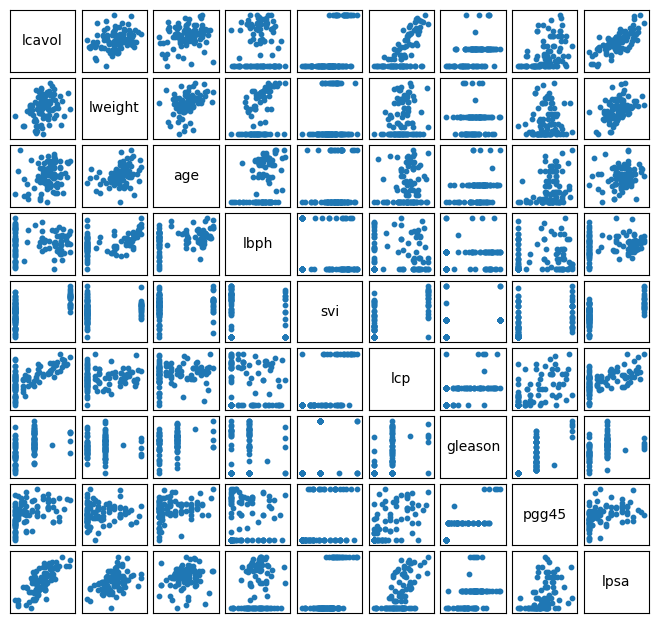

In [23]:
# make a pairplot from scratch
def pairplot(df, figsize=None):
    if figsize is None:
        figsize = (7.10, 6.70)
    n_vars = df.shape[1]
    fig, ax = plt.subplots(figsize=figsize, ncols=n_vars, nrows=n_vars)
    plt.subplots_adjust(
        wspace=0.10, hspace=0.10, left=0.05, right=0.95, bottom=0.05, top=0.95)
    for i in range(n_vars):
        for j in range(n_vars):
            axij = ax[i][j]
            i_name = df.columns[i]
            j_name = df.columns[j]
            axij.set_xticks([])
            axij.set_yticks([])
            axij.margins(0.1)
            if i != j:
                axij.scatter(df[i_name], df[j_name], s=10)
            else:
                axij.text(0.5, 0.5, i_name, fontsize=10,
                          horizontalalignment='center',
                          verticalalignment='center',
                          transform=axij.transAxes)
    return fig, ax


fig, ax = pairplot(df)
plt.show()


**(c)** Based on the generated figure, identify which variables seem the most correlated to `lcavol`. Also, infer the datatype for each of the predictors.

**(d)** Recall the formula of correlation between two vectors and implement it with `numpy`. Explain the difference of your result when compared to `df.corr()`. Change the function `pairplot`to show the correlation coefficient on the upper triangle of the subplots. (Bonus) Use locally weighted scatterplot smoothing (LOWESS) to see the trends between pairs of features with `statsmodels.nonparametric.smoothers_lowess`.

## ▶️ Exercise 2: Linear regression (7 points)

In this exercise, we will perform a multiple linear regression to build a predictive model for the `lcavol` variable. The variables `gleason` and `svi` should be considered as qualitative variables. You can declare them as such with

```
df['svi'] = df['svi'].astype("category")
df['gleason'] = df['gleason'].astype("category")
```

**(a)** Provide the mathematical equation of the regression model (note that you can use LaTeX to write equations) and define the diﬀerent parameters. 

**(b)** Before doing the linear regression of this TP, you will first have to handle the one-hot encoding of the categorical features of the dataframe. One way of doing this is as follows:

```
# encode the categorical features with dummy variables
df_enc = pd.get_dummies(df, dtype=np.float64)
# to drop one dummy column for each predictor
df_enc = df_enc.drop(columns=['svi_0', 'gleason_6'])
# add a column of ones to the dataframe
df_enc['intercept'] = 1
# extract the dataframe for predictors
X = df_enc.drop(columns=['lcavol'])
# get the observed values to predict
y = df['lcavol']
```

- Why did we fix a `dtype` in `pd.get_dummies`?
- Why did we drop two columns after the encoding?
- Why did we add a column of ones to the dataframe?

**(c)** We will use the [`statsmodels`](https://www.statsmodels.org/) package to estimate the coefficients of the multiple linear regression as per:

```
# import required package
import statsmodels.api as sm
# this line does not fit the regression model per se but only builds it
model = sm.OLS(y, X)
# now we actually fit the model, e.g. calculate all of regression parameters
results = model.fit()
```

Use command `results.sumary()` to get the statistical summary of the estimated coefficients. 

- Explain to what correspond the regression coeﬃcients for the lines related to `svi` and `gleason`. 

- What would have happened in the regression if we did not do the one-hot encoding from above?

- Comment the overall results of the regression as well.

**(d)** Use `results.conf_int` to get confidence intervals of level 95% for all the coeﬃcients of the predictors. Comment the results.

**(e)** What can you say about the eﬀects of the `lpsa` variable? Relate your answer to the $p$-value of a hypothesis test and a confidence interval. You can use `results.pvalues`.

**(f)** Implement yourself a function that calculates the values of the parameters and their corresponding $p$-values. Bonus: explain why `numpy.linalg.inv` is not necessarily the best choice for estimating the parameters as compared to `numpy.linalg.solve`.

**(g)** Plot the predicted values of `lcavol` as a function of the actual values. For this, you can can use `results.get_prediction` to get predictions over `X` and then get its `predicted_mean` attribute.

**(h)** Plot the histogram of residuals as well as their qq-plot using `statsmodels` function `qqplot`. Can we admit that the residuals are normally distributed? Compute the residual sum of squares (RSS).

**(i)** What happens if predictors `lpsa` and `lcp` are removed from the multiple linear regression model? Note that you can pass a list of strings to `df.columns.drop` method.

## ▶️ Exercise 3: Best subset selection (5 points)

A regression model that uses $k$ predictors is said to be of size $k$. For instance, 

$$
\texttt{lcavol} = \beta_1 \texttt{lpsa} + \beta_0 + \varepsilon \quad \text{and} \quad \texttt{lcavol} = \beta_1 \texttt{lweight} + \beta_0 + \varepsilon
$$

are models of size one. The regression model without any predictor $\texttt{lcavol} = \beta_0 + \varepsilon$ is a model of size 0.

The goal of this exercise is to select the best model of size $k$ for each $k \in \{0, \dots, 8\}$.

**(a)** Compute the residual sums of squares (RSS) for all models of size $k = 2$. Which model has the smallest RSS? Note that you can use a generator [`itertools.combination`](https://docs.python.org/3/library/itertools.html#itertools.combinations) to automatize for you all the combinations of $k$ elements among $n$.

**(b)** For each value of $k \in \{0, \dots, 8\}$, select the set of predictors that minimizes the RSS. Plot these values as a function of $k$. Provide the names of the selected predictors for each value of $k$.

**(c)** Do you think that minimizing the residual sum of squares is well suited to select the optimal size for the regression models? Justify your answer using what you've learned in class.

## ▶️ Exercise 4: Split-validation (5 points)

You have now found the best model for each of the nine possible model sizes. In the following, we wish to compare these nine diﬀerent regression models.

**(a)** Give a brief overview of split-validation: how it works? Why it is not subject to the same issues raised in
the item (c) of the previous Exercise?

**(b)** Use function `train_test_split` from the `sklearn` package to split the dataset into a training and a validation (or test) partition. You can set `test_size=0.3`. For each of the nine models from before (i.e. those that minimized the RSS for each size $k$), compute the mean prediction error calculated over the samples from the test set and compare it to its corresponding mean training error. Plot a curve for each of these error as a function of size $k$. 

**(c)** Based on the previous results, choose the best model for this dataset, giving the parameter estimates for the model trained on the whole dataset (i.e. without splitting), and explain your choice.

**(d)** What is the main limitation of split-validation ? Illustrate this issue on the cancer dataset. What could
you do to address this problem? Code such alternative method and comment the result. Note that `sklearn` can provide you with many choices. See [here](https://scikit-learn.org/stable/model_selection.html) for more information.

## ▶️ Exercise 5: Conclusion (2 points)

What is your conclusion about the choice of the best model to predict `lcavol` ? Comment your results.